Data Mining Project

In [ ]:
import os
import numpy as np
from glob import glob
from PIL import Image
import torch
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import seaborn as sns

Reading the File

In [2]:
base_path = '/Users/sriramvishals/Documents/Project data'
frames_dir = os.path.join(base_path, 'frames')
masks_dir = os.path.join(base_path, 'annots')
non_path_dir = os.path.join(base_path, 'no_pathology')

Checking the Files 

In [3]:
image_paths = []
labels = []

frame_images = [f for f in os.listdir(frames_dir) if f.endswith('.jpg')]
for img in frame_images:
    mask_path = os.path.join(masks_dir, img.replace('.jpg', '.png'))
    if os.path.exists(mask_path):
        mask = np.array(Image.open(mask_path).convert('L'))
        image_paths.append(os.path.join(frames_dir, img))
        labels.append(1 if np.sum(mask) > 0 else 0)

non_path_images = glob(os.path.join(non_path_dir, '**/*.jpg'), recursive=True)
image_paths.extend(non_path_images)
labels.extend([0] * len(non_path_images))

print(f"Total images: {len(image_paths)}")
print(f"Labels: {sum(labels)} positive, {len(labels) - sum(labels)} negative")
print(f"Class balance: {sum(labels) / len(labels):.2%} positive, {(len(labels) - sum(labels)) / len(labels):.2%} negative")



Total images: 13811
Labels: 373 positive, 13438 negative
Class balance: 2.70% positive, 97.30% negative


In [4]:
print("Frames:", len(os.listdir(frames_dir)))
print("Masks:", len(os.listdir(masks_dir)))
print("Non-pathological:", len(glob(os.path.join(non_path_dir, '**/*.jpg'), recursive=True)))

Frames: 373
Masks: 373
Non-pathological: 13438


Selected Frames: ['/Users/sriramvishals/Documents/Project data/frames/c_50_v_(video_1589.mp4)_f_220.jpg', '/Users/sriramvishals/Documents/Project data/frames/c_9_v_(video_168.mp4)_f_2210.jpg']


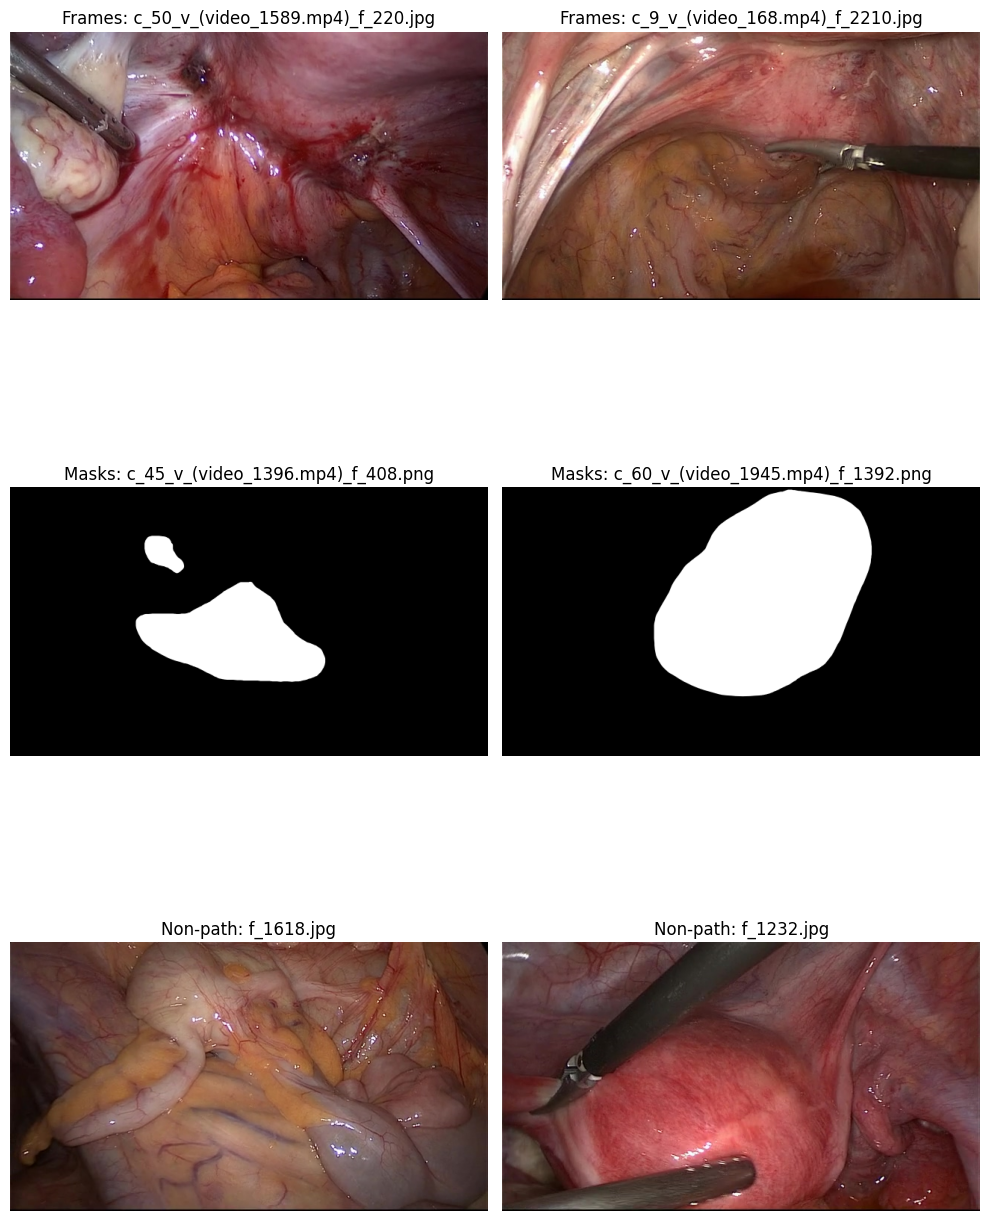

In [5]:
# Redefine list_random_images with explicit path joining
def list_random_images(directory, extension, num_samples=2, recursive=False):
    if recursive:
        files = glob(os.path.join(directory, f'**/*{extension}'), recursive=True)
    else:
        # Explicitly join paths for non-recursive case
        files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(extension)]
    return random.sample(files, min(num_samples, len(files))) if files else []

# Get random images
frame_images = list_random_images(frames_dir, '.jpg', 2)
mask_images = list_random_images(masks_dir, '.png', 2)
non_path_images = list_random_images(non_path_dir, '.jpg', 2, recursive=True)

# Debug: Print selected frame images to verify paths
print("Selected Frames:", frame_images)

# Plot
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
for row, (imgs, cat) in enumerate([(frame_images, "Frames"), (mask_images, "Masks"), (non_path_images, "Non-path")]):
    for col in range(2):
        if col < len(imgs) and os.path.exists(imgs[col]):
            img = Image.open(imgs[col])
            if cat == "Masks":
                img = img.convert('L')
            axes[row][col].imshow(img, cmap='gray' if cat == "Masks" else None)
            axes[row][col].set_title(f"{cat}: {os.path.basename(imgs[col])}")
            axes[row][col].axis('off')
        else:
            axes[row][col].axis('off')
            if col < len(imgs):
                print(f"Skipping {imgs[col]}: File not found")
plt.tight_layout()
plt.show()

Preprocessing

In [6]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class EndoDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.float)



train test split

In [7]:
train_paths, test_paths, y_train, y_test = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)
train_paths, val_paths, y_train, y_val = train_test_split(
    train_paths, y_train, test_size=0.2, stratify=y_train, random_state=42
)

train_dataset = EndoDataset(train_paths, y_train, train_transform)
val_dataset = EndoDataset(val_paths, y_val, val_test_transform)
test_dataset = EndoDataset(test_paths, y_test, val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)

print(f"Train: {len(train_dataset)} images")
print(f"Val: {len(val_dataset)} images")
print(f"Test: {len(test_dataset)} images")

Train: 8838 images
Val: 2210 images
Test: 2763 images


In [8]:
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break


torch.Size([32, 3, 224, 224]) torch.Size([32])


Model Building CNN- Resnet

In [9]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

pos_count = sum(labels)
neg_count = len(labels) - pos_count
pos_weight = torch.tensor([neg_count / pos_count]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

/Users/sriramvishals/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sriramvishals/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, patience=5):
    print("Starting training...")
    best_val_f1 = 0.0
    epochs_no_improve = 0
    best_model_path = os.path.join(base_path, 'best_model.pth')

    train_losses, val_losses, val_f1_scores = [], [], []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1} started")
        model.train()
        train_loss = 0.0
        train_batches = len(train_loader)
        print(f"Processing {train_batches} training batches")
        for i, (images, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)
            if i % 50 == 0:
                print(f"Batch {i}/{train_batches}, Loss: {loss.item():.4f}")
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        print("Starting validation...")
        model.eval()
        val_loss = 0.0
        val_preds, val_labels = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                outputs = model(images).squeeze()
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                val_preds.extend(torch.sigmoid(outputs).cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        val_preds = np.array(val_preds) > 0.5
        precision, recall, f1, _ = precision_recall_fscore_support(val_labels, val_preds, average='binary', zero_division=0)
        val_f1_scores.append(f1)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")

        if f1 > best_val_f1:
            best_val_f1 = f1
            epochs_no_improve = 0
            torch.save(model.state_dict(), best_model_path)
            print(f"Saved best model with F1: {best_val_f1:.4f}")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered!")
                break

    print("Loading best model...")
    model.load_state_dict(torch.load(best_model_path))

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curve')

    plt.subplot(1, 2, 2)
    plt.plot(val_f1_scores, label='Val F1-Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1-Score')
    plt.legend()
    plt.title('Validation F1-Score')
    plt.tight_layout()
    plt.show()

    print("Training completed!")
    return model

In [10]:
def evaluate_model(model, test_loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for images, lbls in tqdm(test_loader, desc="Evaluating"):
            images, lbls = images.to(device), lbls.to(device)
            outputs = model(images).squeeze()
            preds.extend(torch.sigmoid(outputs).cpu().numpy())
            labels.extend(lbls.cpu().numpy())

    preds_binary = np.array(preds) > 0.5
    labels = np.array(labels)

    acc = accuracy_score(labels, preds_binary)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds_binary, average='binary', zero_division=0)
    auc = roc_auc_score(labels, preds)

    print(f"Test Accuracy: {acc:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-Score: {f1:.4f}")
    print(f"Test AUC: {auc:.4f}")

    cm = confusion_matrix(labels, preds_binary)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [11]:
def visualize_gradcam(model, test_loader, num_images=3):
    model.eval()
    target_layer = model.layer4[-1]
    cam = GradCAM(model=model, target_layers=[target_layer], use_cuda=torch.cuda.is_available())

    images_shown = 0
    for images, labels in test_loader:
        images = images.to(device)
        for i in range(images.size(0)):
            if images_shown >= num_images:
                break
            input_img = images[i].unsqueeze(0)
            grayscale_cam = cam(input_img)[0, :]
            img = images[i].cpu().permute(1, 2, 0).numpy()
            img = (img - img.min()) / (img.max() - img.min())
            visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)

            plt.figure(figsize=(6, 4))
            plt.imshow(visualization)
            plt.title(f"Label: {'Endometriosis' if labels[i].item() == 1 else 'No Pathology'}")
            plt.axis('off')
            plt.show()
            images_shown += 1
        if images_shown >= num_images:
            break

In [28]:
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

def visualize_gradcam(model, test_loader, num_images=3):
    model.eval()
    target_layer = model.layer4[-1]
    cam = GradCAM(model=model, target_layers=[target_layer])

    images_shown = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        for i in range(images.size(0)):
            if images_shown >= num_images:
                break

            input_img = images[i].unsqueeze(0)  # shape: [1, 3, 224, 224]
            target = [ClassifierOutputTarget(0)]  # Binary classifier → index 0

            # Generate Grad-CAM
            grayscale_cam = cam(input_tensor=input_img, targets=target)[0, :]
            
            # Normalize image for visualization
            img = images[i].detach().cpu().permute(1, 2, 0).numpy()
            img = (img - img.min()) / (img.max() - img.min())

            visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)

            # Plot
            plt.figure(figsize=(6, 4))
            plt.imshow(visualization)
            plt.title(f"Label: {'Endometriosis' if labels[i].item() == 1 else 'No Pathology'}")
            plt.axis('off')
            plt.show()

            images_shown += 1
        if images_shown >= num_images:
            break


Model Running

Starting training...
Epoch 1 started
Processing 277 training batches


Epoch 1/10:   0%|          | 1/277 [00:02<13:10,  2.87s/it]

Batch 0/277, Loss: 1.5558


Epoch 1/10:  18%|█▊        | 51/277 [02:25<10:32,  2.80s/it]

Batch 50/277, Loss: 0.4061


Epoch 1/10:  36%|███▋      | 101/277 [04:43<08:02,  2.74s/it]

Batch 100/277, Loss: 0.2795


Epoch 1/10:  55%|█████▍    | 151/277 [07:00<05:45,  2.74s/it]

Batch 150/277, Loss: 0.1624


Epoch 1/10:  73%|███████▎  | 201/277 [09:17<03:28,  2.75s/it]

Batch 200/277, Loss: 0.2913


Epoch 1/10:  91%|█████████ | 251/277 [11:35<01:11,  2.74s/it]

Batch 250/277, Loss: 0.1115


Epoch 1/10: 100%|██████████| 277/277 [12:44<00:00,  2.76s/it]


Starting validation...
Epoch 1/10 | Train Loss: 0.4226 | Val Loss: 0.2195 | Val F1: 0.5744 | Precision: 0.4148 | Recall: 0.9333
Saved best model with F1: 0.5744
Epoch 2 started
Processing 277 training batches


Epoch 2/10:   0%|          | 1/277 [00:02<12:47,  2.78s/it]

Batch 0/277, Loss: 0.0850


Epoch 2/10:  18%|█▊        | 51/277 [02:20<10:36,  2.82s/it]

Batch 50/277, Loss: 0.0742


Epoch 2/10:  36%|███▋      | 101/277 [04:39<08:08,  2.78s/it]

Batch 100/277, Loss: 0.2048


Epoch 2/10:  55%|█████▍    | 151/277 [06:57<05:48,  2.77s/it]

Batch 150/277, Loss: 0.1611


Epoch 2/10:  73%|███████▎  | 201/277 [09:15<03:30,  2.77s/it]

Batch 200/277, Loss: 0.2681


Epoch 2/10:  91%|█████████ | 251/277 [11:35<01:12,  2.78s/it]

Batch 250/277, Loss: 0.2617


Epoch 2/10: 100%|██████████| 277/277 [12:45<00:00,  2.76s/it]


Starting validation...
Epoch 2/10 | Train Loss: 0.2119 | Val Loss: 0.1678 | Val F1: 0.6867 | Precision: 0.5377 | Recall: 0.9500
Saved best model with F1: 0.6867
Epoch 3 started
Processing 277 training batches


Epoch 3/10:   0%|          | 1/277 [00:02<12:45,  2.77s/it]

Batch 0/277, Loss: 0.1021


Epoch 3/10:  18%|█▊        | 51/277 [02:21<10:23,  2.76s/it]

Batch 50/277, Loss: 0.0521


Epoch 3/10:  36%|███▋      | 101/277 [04:39<08:05,  2.76s/it]

Batch 100/277, Loss: 0.1952


Epoch 3/10:  55%|█████▍    | 151/277 [06:57<05:48,  2.76s/it]

Batch 150/277, Loss: 0.0325


Epoch 3/10:  73%|███████▎  | 201/277 [09:16<03:29,  2.76s/it]

Batch 200/277, Loss: 0.3489


Epoch 3/10:  91%|█████████ | 251/277 [11:34<01:12,  2.77s/it]

Batch 250/277, Loss: 0.1257


Epoch 3/10: 100%|██████████| 277/277 [12:44<00:00,  2.76s/it]


Starting validation...
Epoch 3/10 | Train Loss: 0.1645 | Val Loss: 0.7513 | Val F1: 0.1810 | Precision: 0.0998 | Recall: 0.9667
Epoch 4 started
Processing 277 training batches


Epoch 4/10:   0%|          | 1/277 [00:02<12:49,  2.79s/it]

Batch 0/277, Loss: 0.0666


Epoch 4/10:  18%|█▊        | 51/277 [02:21<10:27,  2.78s/it]

Batch 50/277, Loss: 0.0233


Epoch 4/10:  36%|███▋      | 101/277 [04:40<08:09,  2.78s/it]

Batch 100/277, Loss: 0.0309


Epoch 4/10:  55%|█████▍    | 151/277 [06:59<05:49,  2.78s/it]

Batch 150/277, Loss: 0.0312


Epoch 4/10:  73%|███████▎  | 201/277 [09:18<03:30,  2.78s/it]

Batch 200/277, Loss: 0.0085


Epoch 4/10:  91%|█████████ | 251/277 [11:37<01:12,  2.80s/it]

Batch 250/277, Loss: 0.0581


Epoch 4/10: 100%|██████████| 277/277 [12:47<00:00,  2.77s/it]


Starting validation...
Epoch 4/10 | Train Loss: 0.1264 | Val Loss: 0.3185 | Val F1: 0.6098 | Precision: 0.4808 | Recall: 0.8333
Epoch 5 started
Processing 277 training batches


Epoch 5/10:   0%|          | 1/277 [00:02<12:51,  2.80s/it]

Batch 0/277, Loss: 0.1159


Epoch 5/10:  18%|█▊        | 51/277 [02:22<10:30,  2.79s/it]

Batch 50/277, Loss: 0.0529


Epoch 5/10:  36%|███▋      | 101/277 [04:42<08:10,  2.79s/it]

Batch 100/277, Loss: 0.0210


Epoch 5/10:  55%|█████▍    | 151/277 [07:01<05:51,  2.79s/it]

Batch 150/277, Loss: 0.0153


Epoch 5/10:  73%|███████▎  | 201/277 [09:21<03:31,  2.79s/it]

Batch 200/277, Loss: 0.0200


Epoch 5/10:  91%|█████████ | 251/277 [11:40<01:12,  2.79s/it]

Batch 250/277, Loss: 0.0310


Epoch 5/10: 100%|██████████| 277/277 [12:50<00:00,  2.78s/it]


Starting validation...
Epoch 5/10 | Train Loss: 0.1245 | Val Loss: 0.1626 | Val F1: 0.9107 | Precision: 0.9808 | Recall: 0.8500
Saved best model with F1: 0.9107
Epoch 6 started
Processing 277 training batches


Epoch 6/10:   0%|          | 1/277 [00:02<12:45,  2.78s/it]

Batch 0/277, Loss: 0.0295


Epoch 6/10:  18%|█▊        | 51/277 [02:21<10:25,  2.77s/it]

Batch 50/277, Loss: 0.0179


Epoch 6/10:  36%|███▋      | 101/277 [04:40<08:09,  2.78s/it]

Batch 100/277, Loss: 0.0451


Epoch 6/10:  55%|█████▍    | 151/277 [07:00<05:47,  2.75s/it]

Batch 150/277, Loss: 0.0235


Epoch 6/10:  73%|███████▎  | 201/277 [09:18<03:29,  2.76s/it]

Batch 200/277, Loss: 0.0408


Epoch 6/10:  91%|█████████ | 251/277 [11:35<01:11,  2.75s/it]

Batch 250/277, Loss: 0.0308


Epoch 6/10: 100%|██████████| 277/277 [12:44<00:00,  2.76s/it]


Starting validation...
Epoch 6/10 | Train Loss: 0.0805 | Val Loss: 0.1636 | Val F1: 0.8682 | Precision: 0.8116 | Recall: 0.9333
Epoch 7 started
Processing 277 training batches


Epoch 7/10:   0%|          | 1/277 [00:02<12:36,  2.74s/it]

Batch 0/277, Loss: 0.0721


Epoch 7/10:  18%|█▊        | 51/277 [02:20<10:21,  2.75s/it]

Batch 50/277, Loss: 0.0378


Epoch 7/10:  36%|███▋      | 101/277 [04:37<08:04,  2.75s/it]

Batch 100/277, Loss: 0.1169


Epoch 7/10:  55%|█████▍    | 151/277 [06:55<05:46,  2.75s/it]

Batch 150/277, Loss: 0.5102


Epoch 7/10:  73%|███████▎  | 201/277 [09:12<03:29,  2.76s/it]

Batch 200/277, Loss: 0.0632


Epoch 7/10:  91%|█████████ | 251/277 [11:30<01:11,  2.76s/it]

Batch 250/277, Loss: 0.0782


Epoch 7/10: 100%|██████████| 277/277 [12:39<00:00,  2.74s/it]


Starting validation...
Epoch 7/10 | Train Loss: 0.0806 | Val Loss: 0.1802 | Val F1: 0.9310 | Precision: 0.9643 | Recall: 0.9000
Saved best model with F1: 0.9310
Epoch 8 started
Processing 277 training batches


Epoch 8/10:   0%|          | 1/277 [00:02<12:51,  2.80s/it]

Batch 0/277, Loss: 0.0417


Epoch 8/10:  18%|█▊        | 51/277 [02:20<10:23,  2.76s/it]

Batch 50/277, Loss: 0.0370


Epoch 8/10:  36%|███▋      | 101/277 [04:38<08:04,  2.75s/it]

Batch 100/277, Loss: 0.0075


Epoch 8/10:  55%|█████▍    | 151/277 [06:56<05:47,  2.76s/it]

Batch 150/277, Loss: 0.0347


Epoch 8/10:  73%|███████▎  | 201/277 [09:15<03:30,  2.77s/it]

Batch 200/277, Loss: 0.0111


Epoch 8/10:  91%|█████████ | 251/277 [11:34<01:14,  2.88s/it]

Batch 250/277, Loss: 0.0838


Epoch 8/10: 100%|██████████| 277/277 [12:44<00:00,  2.76s/it]


Starting validation...
Epoch 8/10 | Train Loss: 0.0453 | Val Loss: 0.1904 | Val F1: 0.9391 | Precision: 0.9818 | Recall: 0.9000
Saved best model with F1: 0.9391
Epoch 9 started
Processing 277 training batches


Epoch 9/10:   0%|          | 1/277 [00:02<12:43,  2.77s/it]

Batch 0/277, Loss: 1.0190


Epoch 9/10:  18%|█▊        | 51/277 [02:21<10:25,  2.77s/it]

Batch 50/277, Loss: 0.0119


Epoch 9/10:  36%|███▋      | 101/277 [04:39<08:04,  2.76s/it]

Batch 100/277, Loss: 0.0356


Epoch 9/10:  55%|█████▍    | 151/277 [06:58<05:49,  2.77s/it]

Batch 150/277, Loss: 0.0184


Epoch 9/10:  73%|███████▎  | 201/277 [09:16<03:30,  2.76s/it]

Batch 200/277, Loss: 0.0124


Epoch 9/10:  91%|█████████ | 251/277 [11:35<01:12,  2.77s/it]

Batch 250/277, Loss: 0.0137


Epoch 9/10: 100%|██████████| 277/277 [12:45<00:00,  2.76s/it]


Starting validation...
Epoch 9/10 | Train Loss: 0.0429 | Val Loss: 0.2883 | Val F1: 0.9189 | Precision: 1.0000 | Recall: 0.8500
Epoch 10 started
Processing 277 training batches


Epoch 10/10:   0%|          | 1/277 [00:02<12:46,  2.78s/it]

Batch 0/277, Loss: 0.0048


Epoch 10/10:  18%|█▊        | 51/277 [02:21<10:26,  2.77s/it]

Batch 50/277, Loss: 0.0036


Epoch 10/10:  36%|███▋      | 101/277 [04:39<08:05,  2.76s/it]

Batch 100/277, Loss: 0.0050


Epoch 10/10:  55%|█████▍    | 151/277 [06:59<05:50,  2.78s/it]

Batch 150/277, Loss: 0.0112


Epoch 10/10:  73%|███████▎  | 201/277 [09:18<03:31,  2.78s/it]

Batch 200/277, Loss: 0.0047


Epoch 10/10:  91%|█████████ | 251/277 [11:37<01:12,  2.77s/it]

Batch 250/277, Loss: 0.0568


Epoch 10/10: 100%|██████████| 277/277 [12:47<00:00,  2.77s/it]


Starting validation...
Epoch 10/10 | Train Loss: 0.0221 | Val Loss: 0.1605 | Val F1: 0.9391 | Precision: 0.9818 | Recall: 0.9000
Loading best model...


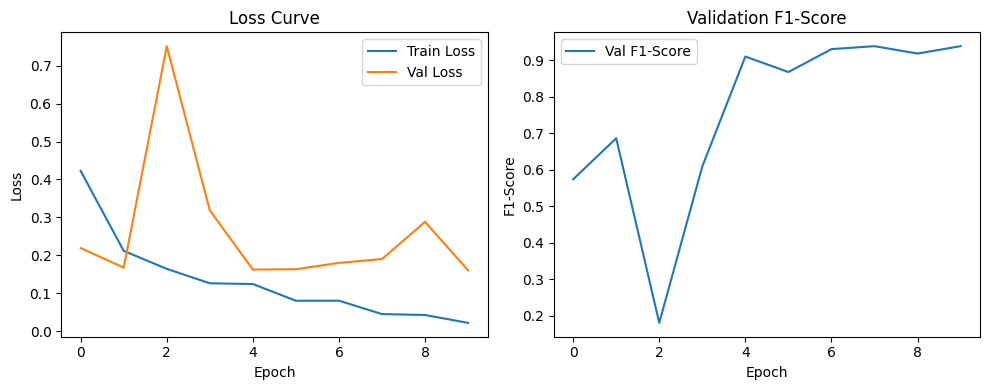

Training completed!


In [16]:
model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=5)


Evaluating: 100%|██████████| 87/87 [01:39<00:00,  1.14s/it]

Test Accuracy: 0.9957
Test Precision: 0.9091
Test Recall: 0.9333
Test F1-Score: 0.9211
Test AUC: 0.9926


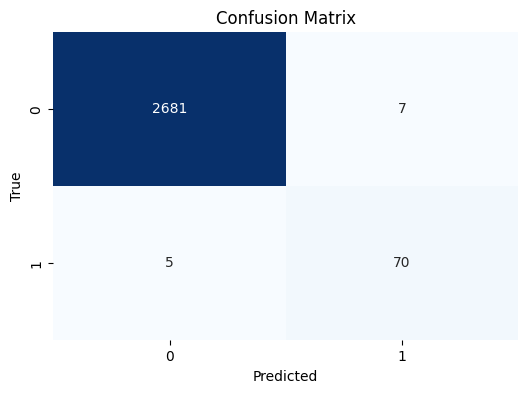

In [26]:
evaluate_model(model, test_loader)

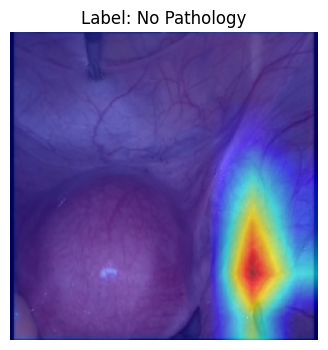

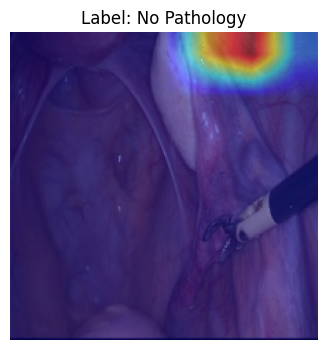

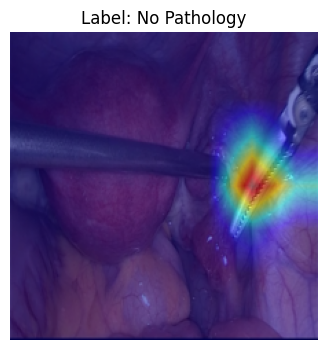

In [36]:
visualize_gradcam(model, test_loader, num_images=3)